**Toy examples**

In this part of the practical session, you will play with some toy data to better understand the classification algorithms seen this morning.

Please answer all questions 

**Deadline**: Upload this notebook, the one about Emotion Recognition and the answers to the theoretical questions to E-Campus. Please verify the exact deadline on E-Campus.

Let's first load the needed packages.

In [19]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt  # for plots
from matplotlib.colors import ListedColormap
from matplotlib import rc
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

import seaborn as sns
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import time

%matplotlib inline
np.random.seed(seed=666)

Here, we define some functions useful for generating and plotting the data

In [20]:
def gaussian_data_generation(n, mean, cov, noise_std):
   # create data which follows a multivariate Gaussian distribution
   # a white (Gaussian) noise is then added to the data
    
    assert cov.shape[0] == cov.shape[1], "Please use only square covariance matrix"    
    assert len(mean) == cov.shape[0], "the dimension of the mean should be equal to the dimension of the covariance matrix"
    
    X = np.random.multivariate_normal(mean, cov, n) # actual data
    X = X + np.random.multivariate_normal(np.zeros(len(mean)), noise_std ** 2 *np.eye(len(mean)), n)  # we add white noise to the data     
    
    return X

def frontiere(f, X, y, step=50):
    # decision boundary of classifier f
    # construct cmap

    min_tot = np.min(X)
    max_tot = np.max(X)
    delta = (max_tot - min_tot) / step
    xx, yy = np.meshgrid(np.arange(min_tot, max_tot, delta),
                         np.arange(min_tot, max_tot, delta))
    z = np.array([f(vec) for vec in np.c_[xx.ravel(), yy.ravel()]])
    z = z.reshape(xx.shape)
    labels = np.unique(z)
    color_blind_list = sns.color_palette("colorblind", labels.shape[0])
    sns.set_palette(color_blind_list)
    my_cmap = ListedColormap(color_blind_list)
    plt.imshow(z, origin='lower', extent=[min_tot, max_tot, min_tot, max_tot],
               interpolation="mitchell", alpha=0.80, cmap=my_cmap)

    ax = plt.gca()
    cbar = plt.colorbar(ticks=labels)
    cbar.ax.set_yticklabels(labels)

    k = np.unique(y).shape[0]
    color_blind_list = sns.color_palette("colorblind", k)
    for i, label in enumerate(y):
        plt.scatter(X[i, 0], X[i, 1], c=[color_blind_list[int(y[i])]],
                    s=80, marker=symlist[int(label)])
    plt.ylim([min_tot, max_tot])
    plt.xlim([min_tot, max_tot])
    ax.get_yaxis().set_ticks([])
    ax.get_xaxis().set_ticks([])
    
def class_int_round(z, n_class):
    # rounding needed to go from real to integer values 
    output = np.round(z).astype(int)
    if isinstance(z, np.ndarray):
        j = z < 0
        output[j] = 0
        k = z > n_class - 1
        output[k] = n_class - 1
    else:
        if output < 0:
            output = 0
        else:
            if output > n_class - 1:
                output = n_class - 1
    return output

The next function is the one you will use to crete the toy data. You can choose among three scenarios: 2, 3 or 4 classes. Each class is composed of 2D points sampled from a multivariate Gaussian distribution. You can choose the number of samples, average and covariance matrix for each class. 

In [21]:
def generate_scenario(n_classes=3):
    
    if n_classes == 2:
        # Example with 2 classes
        n_0=80
        mean_0 = [0, 0]        
        cov_0 = np.array([[1, 0.1], [0.1, 0.9]])
        X_0=gaussian_data_generation(n_0, mean_0, cov_0, 0.1)
        y_0=np.zeros(n_0)
        
        n_1=80
        mean_1 = [3, 2]
        cov_1 = np.array([[0.1, 0], [0, 0.5]])
        X_1=gaussian_data_generation(n_1, mean_1, cov_1, 0.1)
        y_1=np.ones(n_1)
        
        X=np.concatenate((X_0,X_1))
        y=np.concatenate((y_0,y_1))
        
    elif n_classes == 3:
        # Example with 3 classes
        n_0=80
        mean_0 = [0, 0]        
        cov_0 = np.array([[1, 0.1], [0.1, 0.9]])
        X_0=gaussian_data_generation(n_0, mean_0, cov_0, 0.1)
        y_0=np.zeros(n_0)
        
        n_1=80
        mean_1 = [2, 2]
        cov_1 = np.array([[0.1, 0], [0, 0.5]])
        X_1=gaussian_data_generation(n_1, mean_1, cov_1, 0.1)
        y_1=np.ones(n_1)
        
        n_2=80
        mean_2 = [3, 3]
        cov_2 = np.array([[0.5, 0.1], [0.1, 1]])
        X_2=gaussian_data_generation(n_2, mean_2, cov_2, 0.1)
        y_2=2*np.ones(n_2)
        
        X=np.concatenate((X_0,X_1,X_2))
        y=np.concatenate((y_0,y_1,y_2))
    elif n_classes == 4:
        # Example with 4 classes
        n_0=80
        mean_0 = [0, 0]        
        cov_0 = np.array([[1, 0.1], [0.1, 0.9]])
        X_0=gaussian_data_generation(n_0, mean_0, cov_0, 0.1)
        y_0=np.zeros(n_0)
        
        n_1=80
        mean_1 = [3, 3]
        cov_1 = np.array([[0.1, 0], [0, 0.5]])
        X_1=gaussian_data_generation(n_1, mean_1, cov_1, 0.1)
        y_1=np.ones(n_1)
        
        n_2=80
        mean_2 = [0, 3]
        cov_2 = np.array([[0.5, 0.1], [0.1, 1]])
        X_2=gaussian_data_generation(n_2, mean_2, cov_2, 0.1)
        y_2=2*np.ones(n_2)
        
        n_3=80
        mean_3 = [3, 0]
        cov_3 = np.array([[0.9, 0.15], [0.15, 0.8]])
        X_3=gaussian_data_generation(n_3, mean_3, cov_3, 0.1)
        y_3=3*np.ones(n_3)
        
        X=np.concatenate((X_0,X_1,X_2,X_3))
        y=np.concatenate((y_0,y_1,y_2,y_3))  

    return X, y

Let's choose a scenario and generate some data

In [22]:
######## PARAMETER TO CHOOSE THE SCENARIO (number of classes) #######
n_classes=4
#####################################################################

X, y = generate_scenario(n_classes)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [23]:
# np.random.seed(42)

Let's plot the data

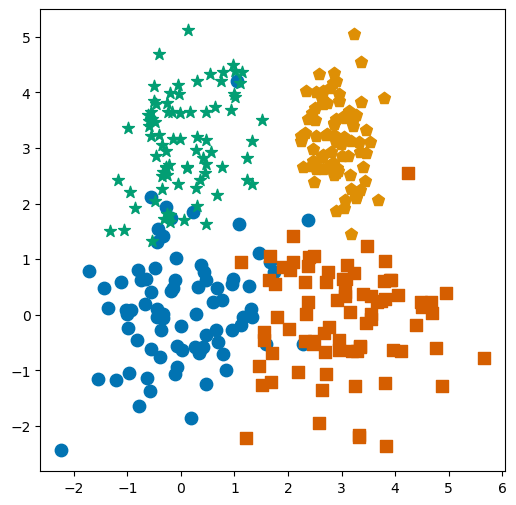

In [24]:
fig1 = plt.figure(figsize=(6, 6))
ax = plt.gca()
min_tot = np.min(X)
max_tot = np.max(X)
symlist = ['o', 'p', '*', 's', '+', 'x', 'D', 'v', '-', '^']
k = np.unique(y).shape[0]
color_blind_list = sns.color_palette("colorblind", k)
for i, label in enumerate(y):
    plt.scatter(X[i, 0], X[i, 1], c=[color_blind_list[int(y[i])]],
                s=80, marker=symlist[int(label)])
#ax.get_yaxis().set_ticks([])
#ax.get_xaxis().set_ticks([])

As first classifier, we can use a simple linear regression where we  transform in integers the predictions.

 **Question**: look at the function 'class_int_round'. Explain what it does.

 **Answer**: the function class_int_round takes as input a vector of real numbers or a real number itself. In the case of a vector it returns a vector of integers, where each element is the rounded value of the corresponding element of the input vector in the range [0,n-1]. In the case of a real number it returns the rounded value of the input number in this same range.

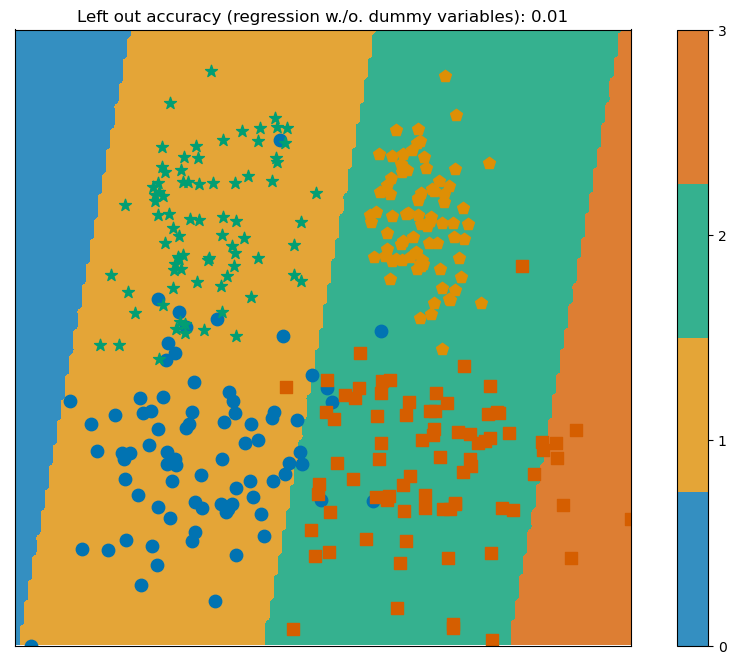

In [25]:
##############################################################################
# Naive linear regression on raw observations
##############################################################################

resolution_param = 150  # 500 for nice plotting, 50 for fast version
regr = LinearRegression()
regr.fit(X_train, y_train)
y_pred_test = class_int_round(regr.predict(X_test), n_classes)

# Plotting part
fig0 = plt.figure(figsize=(12, 8))
title = "Left out accuracy (regression w./o. dummy variables)" + \
        ": {:.2f}".format(accuracy_score(y_test, y_pred_test))
plt.title(title)

def f(xx):
    """Classifier"""
    return class_int_round(regr.predict(xx.reshape(1, -1)), n_classes)
frontiere(f, X, y, step=resolution_param)

plt.show()

Instead of using this simple strategy, we can also use a *OneHotEncoder*.

**Question**: Do you see any difference in the resulting decision boundaries ? Which is the best strategy in your opinion ? Why ?

**Answer**: In this specific case, one-hot encoding seems a better strategy since the labels are better divided in four classes. In general, one-hot encoding is a better strategy compared to ordinal encoding since it allows to better represent the data and to avoid the problem of the order of the labels. However, it can lead to a very high dimensionality of the data, which can be a problem for some algorithms. Therefore, the accuracy of the model with one-hot encoding is much better than the accuracy of the model with ordinal encoding.

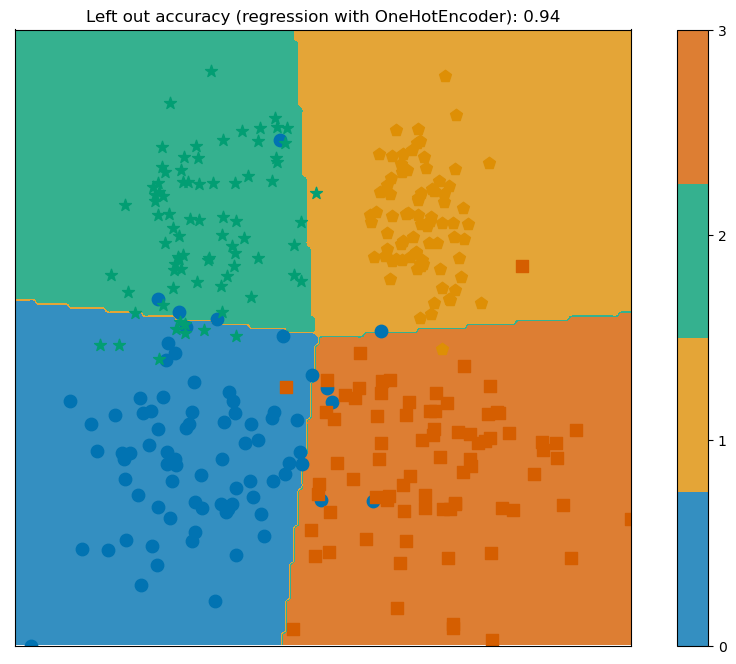

In [26]:
##############################################################################
# Naive linear regression on dummy variables (OneHotEncoder)
##############################################################################
resolution_param = 150                                 # 500 for nice plotting, 50 for fast version
enc = OneHotEncoder(categories='auto')                 # default OneHotEncoder
enc.fit(y_train.reshape(-1, 1))                        # fit on training set
Y = enc.transform(y_train.reshape(-1, 1)).toarray()    # transform training set to dummy variables (one-hot encoding) 
regr_multi = LinearRegression()                        # linear regression
regr_multi.fit(X_train, Y)                            # fit on training set
proba_vector_test = regr_multi.predict(X_test)
y_pred_test = class_int_round(regr.predict(X_test), n_classes)

# performance evaluation on new dataset
y_pred_test = np.argmax(proba_vector_test, axis=1)
title = "Left out accuracy (regression with OneHotEncoder)" + \
        ": {:.2f}".format(accuracy_score(y_test, y_pred_test))

# Plotting part
fig1 = plt.figure(figsize=(12, 8))
plt.title(title)


def f(xx):
    """Classifier"""
    return np.argmax(regr_multi.predict(xx.reshape(1, -1)))
frontiere(f, X, y, step=resolution_param)

plt.show()

Let's use the other strategies seen this morning.

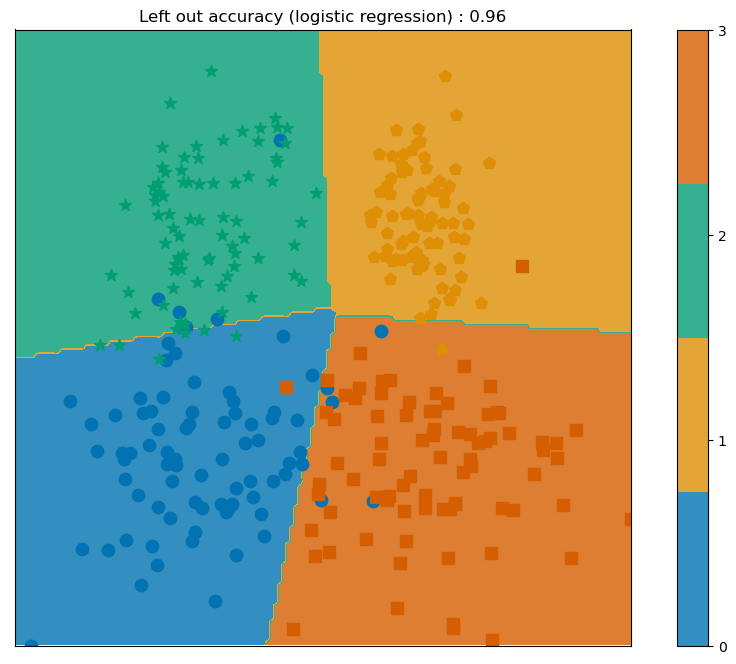

In [27]:
##############################################################################
# Logistic regression
##############################################################################
resolution_param = 150  
clf = LogisticRegression(solver='lbfgs',multi_class='ovr') # you can also try multi_class='multinomial', 
clf.fit(X_train, y_train)
y_logit_test = clf.predict(X_test)
title = "Left out accuracy (logistic regression) " + \
        ": {:.2f}".format(accuracy_score(y_test, y_logit_test))
fig2 = plt.figure(figsize=(12, 8))
plt.title(title)


def f(xx):
    """Classifier"""
    return int(clf.predict(xx.reshape(1, -1)))
frontiere(f, X, y, step=resolution_param)

plt.show()

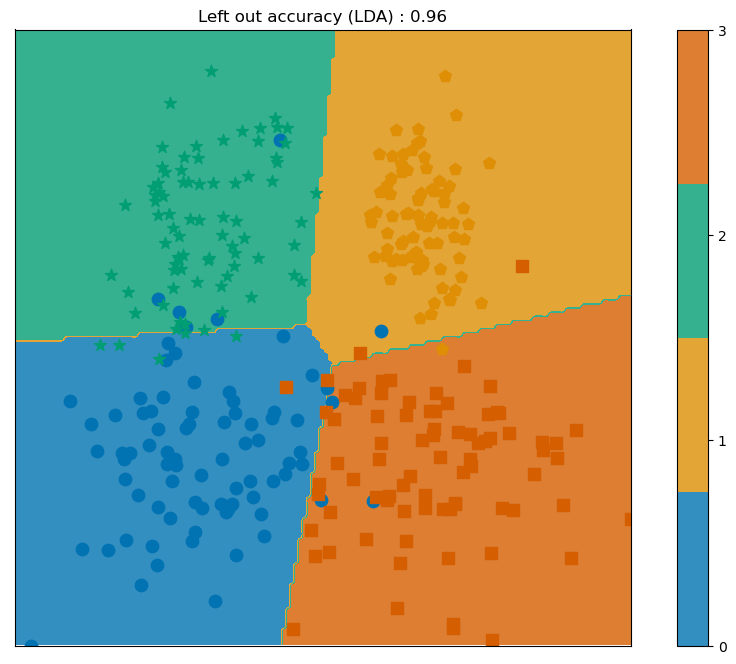

In [28]:
##############################################################################
# LDA
##############################################################################
resolution_param = 150  
clf_LDA = LinearDiscriminantAnalysis()
clf_LDA.fit(X_train, y_train)
y_LDA_test = clf_LDA.predict(X_test)

title = "Left out accuracy (LDA) " + \
        ": {:.2f}".format(accuracy_score(y_test, y_LDA_test))
fig2 = plt.figure(figsize=(12, 8))
plt.title(title)


def f(xx):
    """Classifier"""
    return int(clf_LDA.predict(xx.reshape(1, -1)))
frontiere(f, X, y, step=resolution_param)

plt.show()

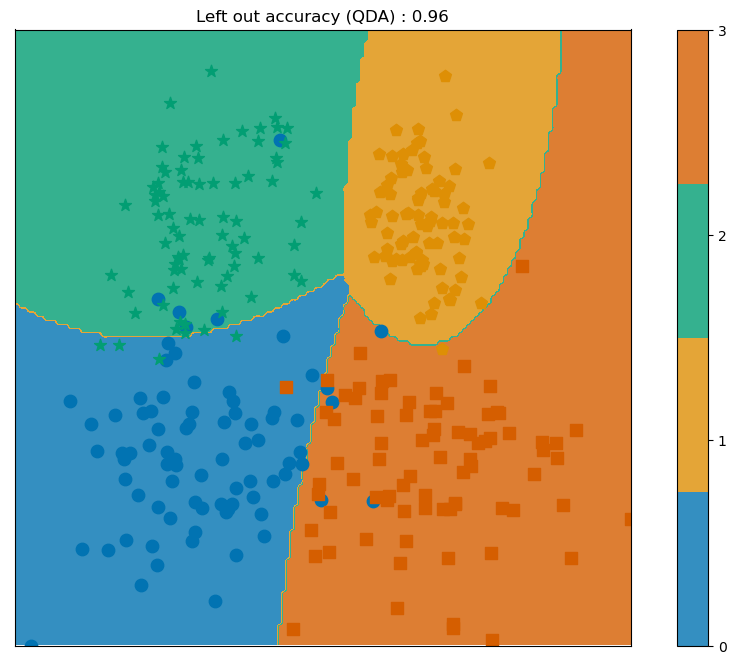

In [29]:
##############################################################################
# QDA
##############################################################################
resolution_param = 150 
clf_QDA = QuadraticDiscriminantAnalysis()
clf_QDA.fit(X_train, y_train)
y_QDA_test = clf_QDA.predict(X_test)
title = "Left out accuracy (QDA) " + \
        ": {:.2f}".format(accuracy_score(y_test, y_QDA_test))
fig2 = plt.figure(figsize=(12, 8))
plt.title(title)


def f(xx):
    """Classifier"""
    return int(clf_QDA.predict(xx.reshape(1, -1)))
frontiere(f, X, y, step=resolution_param)

plt.show()

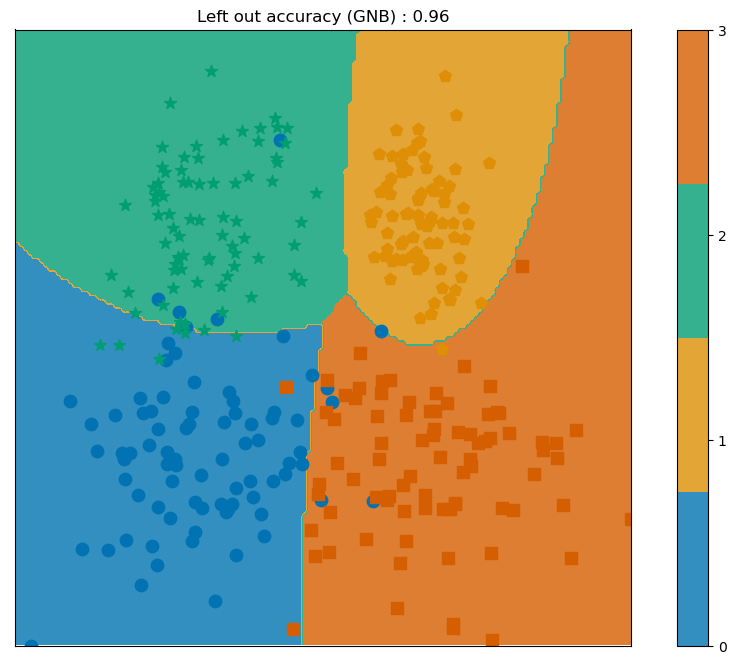

In [30]:
##############################################################################
# Naive Bayes 
##############################################################################
resolution_param = 150  
clf_GNB = GaussianNB()
clf_GNB.fit(X_train, y_train)

y_test_GNB = clf_GNB.predict(X_test)

title = "Left out accuracy (GNB) " + \
        ": {:.2f}".format(accuracy_score(y_test, y_test_GNB))
fig2 = plt.figure(figsize=(12, 8))
plt.title(title)


def f(xx):
    """Classifier"""
    return int(clf_GNB.predict(xx.reshape(1, -1)))
frontiere(f, X, y, step=resolution_param)

plt.show()

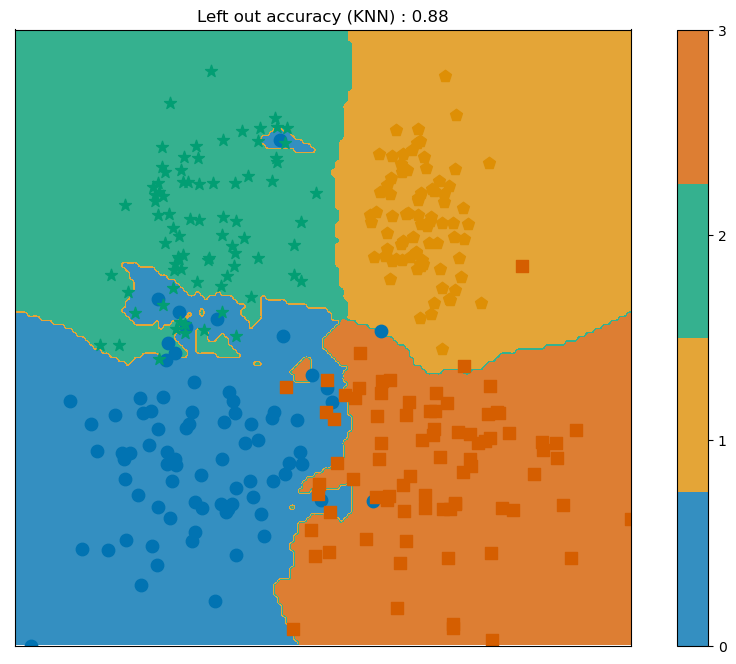

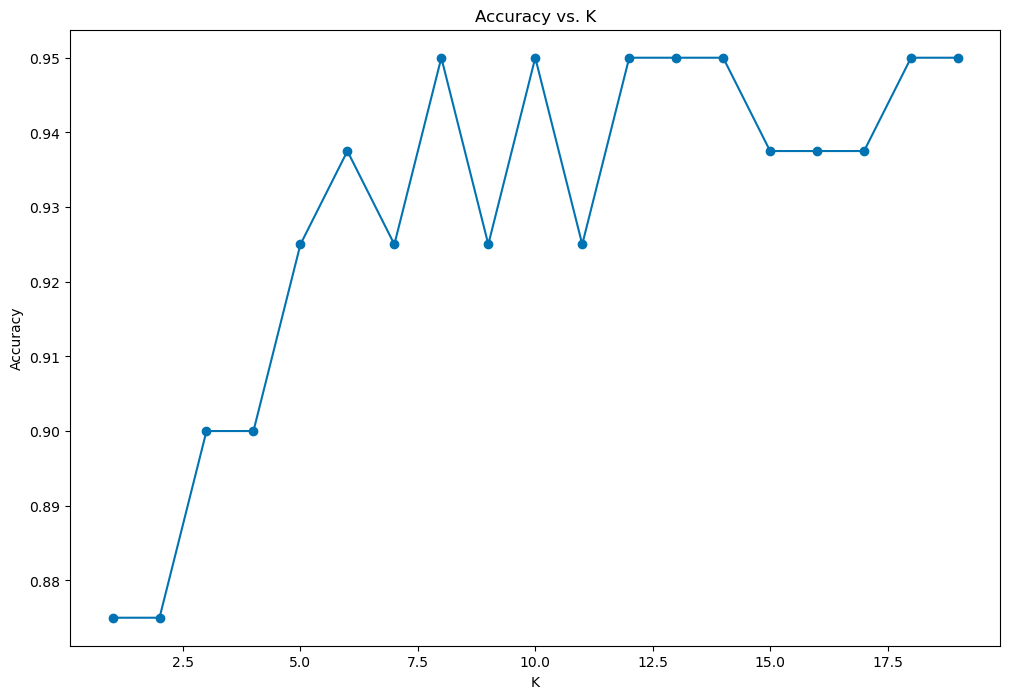

In [31]:
##############################################################################
# KNN
##############################################################################
resolution_param = 150  
clf_KNN = KNeighborsClassifier()
clf_KNN.n_neighbors=2

clf_KNN.fit(X_train, y_train)
y_KNN_test = clf_KNN.predict(X_test)

title = "Left out accuracy (KNN) " + \
        ": {:.2f}".format(accuracy_score(y_test, y_KNN_test));
fig2 = plt.figure(figsize=(12, 8));
plt.title(title);

def f(xx):
    """Classifier"""
    return int(clf_KNN.predict(xx.reshape(1, -1)));
frontiere(f, X, y, step=resolution_param);

plt.show()

# Finding the best K
K = np.arange(1, 20)
scores = []
for k in K:
    clf_KNN.n_neighbors = k
    clf_KNN.fit(X_train, y_train)
    y_KNN_test = clf_KNN.predict(X_test)
    scores.append(accuracy_score(y_test, y_KNN_test))
    
plt.figure(figsize=(12, 8))
plt.plot(K, scores, 'o-')
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. K')
plt.show()


In [32]:
import pandas as pd

print("Correlation Matrix for", n_classes, "classes")
df = pd.DataFrame(X_train)
cov_matrix = pd.DataFrame.cov(df)
print(df.corr(), "\n")


Correlation Matrix for 4 classes
          0         1
0  1.000000  0.004909
1  0.004909  1.000000 



In [33]:
import pandas as pd

print("Covariance Matrix for", n_classes, "classes")
df = pd.DataFrame(X_train)
cov_matrix = pd.DataFrame.cov(df)
print(df.cov(), "\n")


Covariance Matrix for 4 classes
          0         1
0  2.826916  0.014932
1  0.014932  3.272481 



**Questions**:


*   Describe the decision boundaries of the methods. Are all linear ?

    The decision boundaries are not all linear. For the Naive Linear Regression (with and without One-hot encoding), Logistic Regression and LDA the decision boundaries are linear. 
    
    For the QDA and GNB the decision boundaries are quadratic and are very similar for most cases. For the KNN the decision boundaries does not follows a specific pattern.
    
    It is important to notice that for the Naive Linear Regression the decision boundaries are always parallel, which makes the results for 4 classes or more very poor.

    In KNN the decision boundaries are more complex, dependending on several factors, including the number of neighbors, the distance metric, the distribution of the training data and the weights. In this case, the decision boundaries are not linear, neither quadratic either.

*   Using the following code, compare the computational time and the test accuracy of the different methods in the three scenarios. Comment the results.

    First, it is important to notice that the data is randomly generated from a Gaussian distribution, so the results may vary from one execution to another, even if the number of classes is the same.

    In several attempts, Linear Discriminant Analysis (LDA) presents a greater (or equal) accuracy when compared to the other models for the cases of 2 and 4 classes, while the performance for 3 classes is poor. This can be explained by two facts: 
    
        1. Sometimes, in the case of 3 classes there are many datapoints overlapped and in this case the class means and covariances can be biased and, consequently, not well estimated, which leads to a inaccurate modeling of the class distributions.
    
        2. The variables are strongly correlated (as it is possible to observe above), which means that the variables are not independent and changes in one variable may be strongly associated with changes in another variable. This can lead to multicollinearity and, as a consequence, the covariance matrices can be poorly estimated, affecting the accuracy of the discriminant function. 

    By the way, many models face a considerable drop in performance in the case of 3 classes, mainly LDA and Naive Linear Regression. The latter has several limitations as it simply assumes that the variables are linear and that there are no other factors that may affect the outcome, which is not the case. 

    The best results for all the cases were achieved with Logistic Regression, Quadratic Discriminant Analysis (QDA), Gaussian Naive Bayes (GNB) and KNN. As expected, for the GNB model the accuracy is higher since the data is generated from a Gaussian distribution. 

    In some cases (putting a seed(42), for example), it is possible to come across the problem of complete separation when there is a variable (or a set of variables) that can perfectly separate the classes. In this cases,  the coefficients of the input variables cannot be uniquely determined, since any linear combination of the input variables can be used to predict the output variable. Therefore, the accuracy can be 1.0 even when that is not really the case. However, this problem is not very common in practice.



In [34]:
# example using KNN
time_start = time.perf_counter()
clf_KNN.fit(X_train, y_train)
y_KNN_test = clf_KNN.predict(X_test)
time_elapsed = (time.perf_counter() - time_start)
print('Computational time:', "%.2f" %time_elapsed, 's ; Test accuracy KNN', "%.2f" %accuracy_score(y_test, y_KNN_test))

Computational time: 0.01 s ; Test accuracy KNN 0.95
